In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from src.utils.filters import MovingAvgTime, get_factors, MovingAvgFreq
from src.utils.schedule import linear_schedule
import numpy as np

<Axes: xlabel='date'>

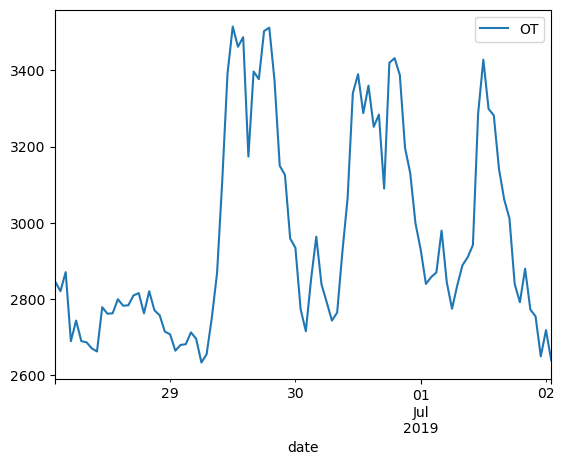

In [2]:
seq_len = 96
df = pd.read_csv(
    # "/home/user/data/THU-timeseries/ETT-small/ETTh2.csv",
    "/home/user/workspaces/THU-timeseries/electricity/electricity.csv",
    index_col=0,
    parse_dates=True,
)[["OT"]]
df = df[-seq_len:]
df = df.astype(float)
df.plot()

DDPM

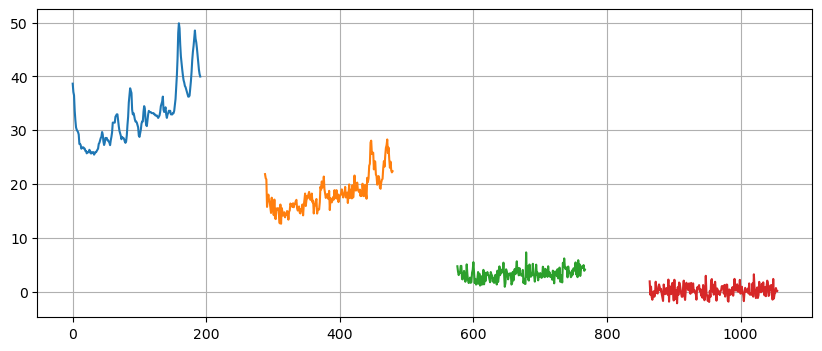

In [3]:
x = df.values.flatten()
x = torch.from_numpy(x)
T = 100
tau = np.linspace(0, T-1, num=4, dtype=int)
a = np.linspace(1, 0.4, num=4)
ns = linear_schedule(T, max_beta=0.2)
alpha_bars = ns["alpha_bars"]

fig, ax = plt.subplots(figsize=[10,4])
x_anchor = []
x_anchor_end = []
t_start = 0
for i in range(len(tau)):
    t_end = t_start + len(x)
    t_axis = range(t_start, t_end)
    x_anchor.append((t_start + t_end)//2)
    x_anchor_end.append(t_end)
    noise = torch.randn_like(x)
    mu_coeff = torch.sqrt(alpha_bars[tau[i]])
    var_coeff = torch.sqrt(1 - alpha_bars[tau[i]])
    # print(mu_coeff)
    # print(var_coeff)
    x_noisy = mu_coeff * x + var_coeff * noise
    t_start += int(len(x)*1.5)
        
    
    ax.plot(t_axis, x_noisy)
    # ax.hist(x_noisy, bins=20, density=True)
ax.grid()
    
# create an index for each tick position
xi = list(range(len(x)))
# ax.set_xticks(x_anchor , [f't={tt}' for tt in tau])
# ax.set_xticks(x_anchor + x_anchor_end[:-1], [f't={tt}' for tt in tau] + ['...' for _ in x_anchor_end[:-1]])
# ax.set_xticks(x_anchor_end, ['...' for _ in x_anchor_end])


MAD in Time

In [9]:
ks = get_factors(seq_len)
# print(len(ks))
# ks = ks[::3]
# ks = list(range(2, seq_len+1))
# real_steps = list(range(2, seq_len+1))
# fig, axs = plt.subplots(ceil(len(ks) / 3), 3, figsize=[6.4*2, 4.8*2])
# axs = axs.flatten()
# betas = torch.load("/home/user/data/FrequencyDiffusion/savings/etth2_192_S/stdschedule_norm_True.pt")
# betas = torch.sqrt(1-betas**2).float()
raw_ = torch.from_numpy(df.values).reshape(1, -1, 1).float()
mean = torch.mean(raw_, dim=1, keepdim=True)
stdev = torch.sqrt(torch.var(raw_, dim=1, keepdim=True, unbiased=False) + 1e-6)
# print(stdev)
# x_norm = raw_
x_norm = (raw_ - mean) / stdev
std_orig = torch.sqrt(torch.var(x_norm, dim=1, keepdim=True, unbiased=False) + 1e-6)

all_x, all_K = [], []
for i, k in enumerate(ks):
    mat = MovingAvgTime(k, seq_length=seq_len, stride=k)
    filtered_ = mat(x_norm)
    # filtered_ = torch.nn.functional.interpolate(
    #             filtered_.permute(0, 2, 1),
    #             size=seq_len - k + 1,
    #             mode="nearest-exact",
    #         )
    # filtered_ = filtered_[..., :: k].permute(0, 2, 1)
            
    # print(filtered_.flatten())
    std_new = torch.sqrt(torch.var(filtered_, dim=1, keepdim=True, unbiased=False) + 1e-6)
    ratio = std_new / std_orig  
    # print(ratio)
     
    noisy_x = filtered_ + torch.randn_like(filtered_) * 0.2

    # std_noisy_x = torch.sqrt(torch.var(noisy_x, dim=1, keepdim=True, unbiased=False) + 1e-6)
    # filtered_ = torch.nn.functional.interpolate(
    #             filtered_.permute(0, 2, 1),
    #             size=288 - k + 1, mode='nearest-exact'
    #         )[..., :: k]
    if i > 0:
        noise = 0
        # noise = torch.randn_like(filtered_.flatten()) * betas[real_steps.index(k)]
    else:
        noise = 0
    # axs[i].plot(noisy_x.flatten(), lw=2.5, c='C1')
    # axs[i].set_title(f"ks={k}")
    # axs[i].set_ylim([-2.5,2.5])
    all_x.append(filtered_)
    all_K.append(mat.K)
# fig.tight_layout()
all_x = torch.stack(all_x)
all_K = torch.stack(all_K)
print(all_x.shape)
all_K.shape

torch.Size([12, 1, 96, 1])


torch.Size([12, 96, 96])

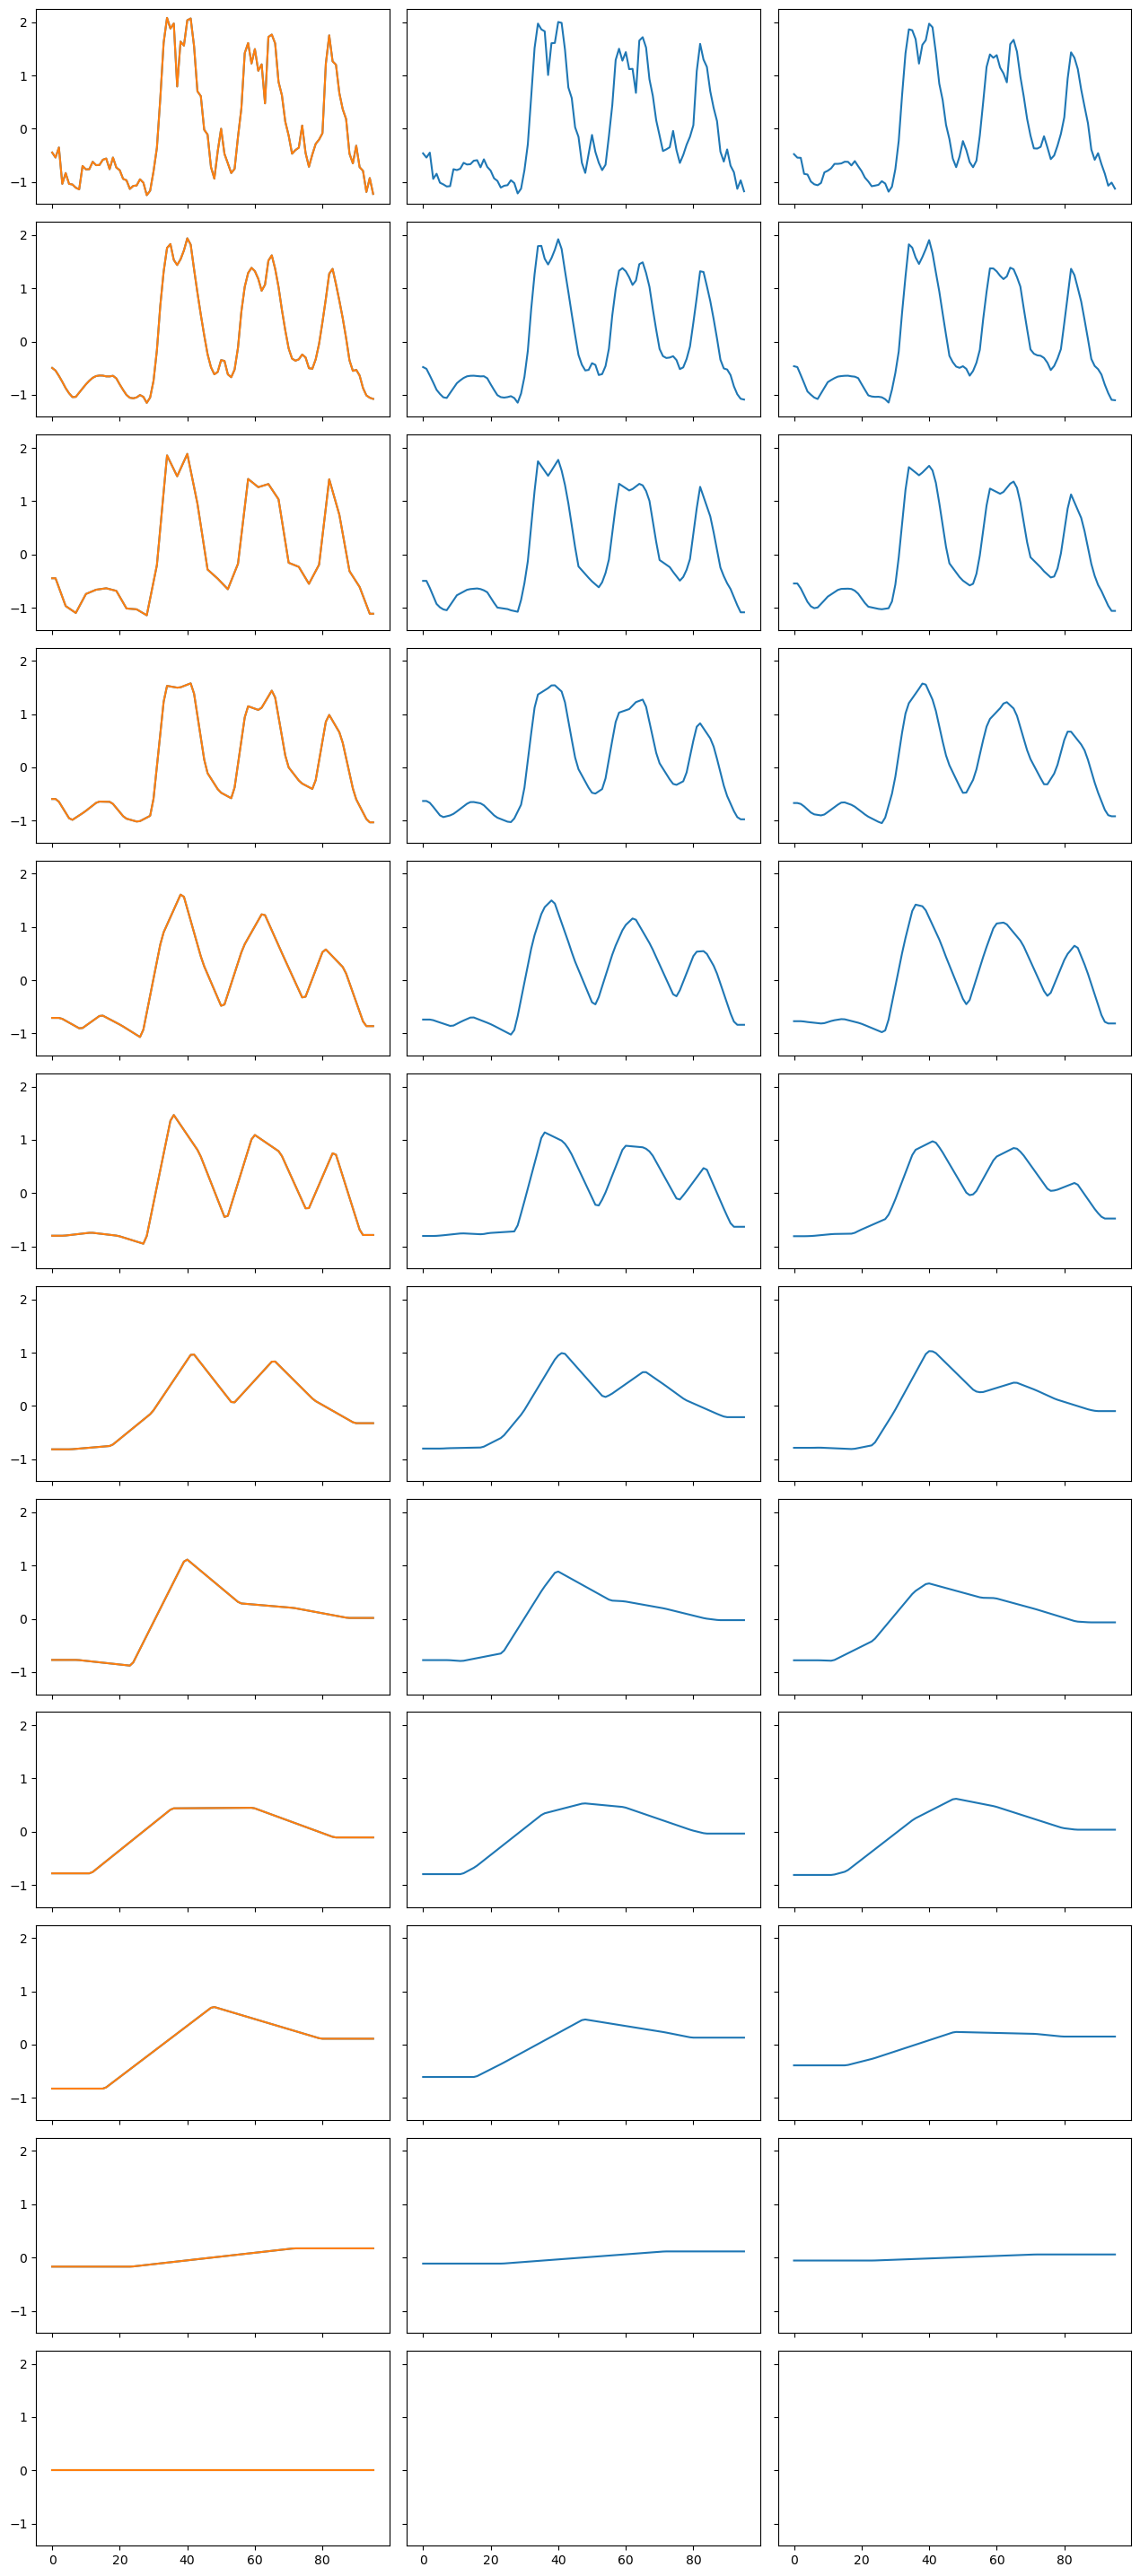

In [10]:
all_x = all_x.squeeze().unsqueeze(0).permute(0, 2, 1)
all_K = all_K.flatten(1).unsqueeze(0).permute(0, 2, 1)

interp_all_x = torch.nn.functional.interpolate(
    all_x, size=34, mode="linear", align_corners=True
)
interp_all_K = (
    torch.nn.functional.interpolate(all_K, size=34, mode="linear", align_corners=True)
    .squeeze()
    .reshape(seq_len, seq_len, -1)
)
interp_all_x.shape
interp_all_K.shape
# print(interp_all_x.shape)

# print(interp_all_x[:,:1])
# print(all_x[:,:1])

interp_all_x = interp_all_x.squeeze().T
fig, axs = plt.subplots(
    ceil(len(interp_all_x) / 3), 3, figsize=[6.4 * 2, 4.8 * 6], sharex=True, sharey=True
)
axs = axs.flatten()
for i in range(len(interp_all_x)):
    kx = interp_all_K[..., i] @ x_norm
    # axs[i].scatter(interp_all_x[i].flatten(), kx.flatten())
    # axs[i].plot(interp_all_x[i].flatten())
    axs[i].plot(kx.flatten())
    if i % 3 == 0:
        axs[i].plot(all_x[..., i // 3].flatten())
fig.tight_layout()

In [ ]:
ks = [1]+get_factors(288) + [288]
real_steps = list(range(2, 289))
fig, axs = plt.subplots(ceil(len(ks)/3), 3, figsize=(15, 15))
axs = axs.flatten()
betas = torch.load('/home/user/data/FrequencyDiffusion/savings/empirical.pt')
# betas = torch.sqrt(1-betas**2)
raw_ = torch.from_numpy(df.values).reshape(1,-1,1)
mean = torch.mean(raw_, dim=1, keepdim=True)
stdev = torch.sqrt(torch.var(raw_, dim=1, keepdim=True, unbiased=False) + 1e-6)
x_norm = (raw_ - mean) / stdev

for i, k in enumerate(ks):
    mat = MovingAvgTime(k)
    filtered_ = mat(x_norm)
    # filtered_ = torch.nn.functional.interpolate(
    #             filtered_.permute(0, 2, 1),
    #             size=288 - k + 1, mode='nearest-exact'
    #         )[..., :: k]
    if i > 0:
        # print(betas[real_steps.index(k)])
        
        noise = torch.randn_like(filtered_.flatten())*betas[real_steps.index(k)]
    else:
        noise = 0
    axs[i].plot(filtered_.flatten() + noise)
    axs[i].set_title(f'ks={k}')
    axs[i].set_ylim(-3,3)
fig.tight_layout()

MAD in Freq

In [ ]:
ks = [1]+get_factors(seq_len) + [seq_len]
# ks = np.linspace(1, 192, 24)
real_steps = list(range(2, seq_len))

fig, axs = plt.subplots(ceil(len(ks)/3), 3, figsize=(15, 15))
axs = axs.flatten()
df_fft = torch.from_numpy(df.values).reshape(1,-1,1).float()
df_fft = torch.fft.rfft(df_fft, dim=1, norm='ortho')

for i, k in enumerate(ks):
    maf = MovingAvgFreq(k, seq_length=seq_len)
    betas = 1 - (maf.K.diag().conj() * maf.K.diag()).real
    betas = torch.sqrt(betas + 1e-6)
    
    filtered_ = maf(df_fft)
    time_filtered = torch.fft.irfft(filtered_, dim=1, norm='ortho').flatten()
    print(time_filtered[k - 1 :: k])
    axs[i].plot(time_filtered)
    # axs[i].plot(betas)
    filtered_ += torch.randn_like(filtered_) * betas.reshape(1, -1, 1)
    degraded_df = torch.fft.irfft(filtered_, dim=1, norm='ortho')
    
    # axs[i].plot(filtered_.abs().flatten())
    # axs[i].set_yscale('log')
    axs[i].set_title(f'ks={k}')
fig.tight_layout()

In [ ]:
betas = []
ks = [i for i in range(2,289)]
for i, k in enumerate(ks):
    maf = MovingAvgFreq(k, seq_length=288)
    coeff = maf.Hw
    # beta = 1 - coeff * coeff.conj()
    # # print(beta.real)
    # beta = torch.sqrt(beta.real + 1e-6)
    # break
    # beta = torch.sqrt(1 - maf.Hw.flatten()**2)
    
    # print(torch.sqrt(1 - maf.Hw**2))
#     R = torch.diag(maf.Hw.flatten())
#     beta = torch.sqrt((1 - (R @ torch.conj(R).T).real).diag())
    betas.append(coeff)

betas = torch.stack(betas)
betas = 1 - (betas.abs()**2)
betas = torch.sqrt(betas + 1e-6)
print(betas.shape)
print((betas == torch.nan).flatten().sum())
# print(betas[:,0])
# print(betas.real)
# print(betas.abs())
# print(betas[:,0])
# plt.plot(betas[:,0])
plt.plot(betas.squeeze()[:,:5])

Read std_schedule

In [ ]:
seq_len = 96
ks = get_factors(seq_len)
all_K_norm = []
for i in ks:
    kernel_size = i
    stride = kernel_size
    K = torch.zeros(seq_len, int((seq_len - kernel_size) / stride + 1))
    start = 0
    for i in range(K.shape[1]):
        end = start + kernel_size
        K[start:end, i] = 1 / kernel_size
        start += stride
    print(K)
            
    K_norm = ((K)**2).sum().sqrt()
    print(K_norm)
    all_K_norm.append(K_norm)
import matplotlib.pyplot as plt
plt.plot(ks, all_K_norm)

In [ ]:
import torch
import matplotlib.pyplot as plt
betas = torch.load('/home/user/data/FrequencyDiffusion/savings/ettm2_96_S/stdschedule_norm_FO_True_SETKS_True.pt')
# betas = torch.sqrt(1 - betas**2)
print(betas)
print(1/betas)
plt.plot(betas)
plt.plot(1/betas[:-1])

In [13]:
seq_length = 720
diffusion_steps = 100
# scale_max = (diffusion_steps - 1) / (10 ** len(str(diffusion_steps - 1)))
kernel_size = get_factors(seq_length)
print(len(kernel_size))
interp_k = round((diffusion_steps - len(kernel_size)) / (len(kernel_size) - 1))
print(interp_k)
sample_steps = list(range(diffusion_steps))
sample_steps.reverse()

print(sample_steps)
# print(len(sample_steps[::interp_k]))
# print(len(kernel_size))

fast_sample = False
start_ks = 2

if fast_sample:
    sample_steps = sample_steps[:: interp_k + 1]
    print(sample_steps)
    if 0 not in sample_steps:
        sample_steps.append(0)
assert 0 in sample_steps
if start_ks is not None:
    start_idx = kernel_size.index(start_ks)
    start_idx = round(start_idx / (len(kernel_size) - 1) * (len(sample_steps) - 1))
    start_idx = len(sample_steps) - 1 - start_idx
    sample_steps = sample_steps[start_idx:]

    # if start_ks is not None:
    #     sample_steps = scaled_ks[kernel_size.index(args.start_ks) + 1] * diffusion_steps
    #     sample_steps = list(range(sample_steps))

print(sample_steps)
print(len(sample_steps))

30
2
[99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[3, 2, 1, 0]
4
